In [6]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import bilby
import numpy as np

from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
%matplotlib inline

import hphc

In [10]:
outdir = 'outdir_new_model'
label = 'create_your_own_source_model'
sampling_frequency = 4096
duration = 1

In [11]:
'''
mass_1=10.0 
mass_2=10.0
luminosity_distance=100.0
theta_jn=np.pi/3
psi=np.pi/3
phase=0.0
geocent_time=0.0
ra=1.375
dec=-1.2108

frequency = np.arange(20,1005,2)
hf0 = []
for f in frequency:
    arg_plus = {'iota_':theta_jn, 'beta_':psi, 'D_':luminosity_distance , 'm1_':mass_1, 'm2_':mass_2, 'f_':f, 'f0_':20.0, 'Fp_':1.0, 'Fc_':0.0, 'et0_':0.1, 'phic_':phase, 'tc_':geocent_time}

    fn = hphc.Fn(**arg_plus)
    hf0 = np.append(hf0,fn.h_tilde())
    
'''

In [7]:
# Here we define our source model - this is the sine-Gaussian model in the
# frequency domain.
def sine_gaussian(frequency_array, mass_1, mass_2, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec):

    h_plus = []
    h_cross = []
    
    for f in frequency_array:
        arg_plus = {'iota_':theta_jn, 'beta_':psi, 'D_':luminosity_distance , 'm1_':mass_1, 'm2_':mass_2, 'f_':f, 'f0_':20.0, 'Fp_':1.0, 'Fc_':0.0, 'et0_':0.1, 'phic_':phase, 'tc_':geocent_time}

        arg_cross = {'iota_':theta_jn, 'beta_':psi, 'D_':luminosity_distance , 'm1_':mass_1, 'm2_':mass_2, 'f_':f, 'f0_':20.0, 'Fp_':0.0, 'Fc_':1.0, 'et0_':0.1, 'phic_':phase, 'tc_':geocent_time}

        fplus = hphc.Fn(**arg_plus)
        h_plus = np.append(h_plus,fplus.h_tilde())

        fcross = hphc.Fn(**arg_cross)
        h_cross = np.append(h_cross,fcross.h_tilde())

    return {'plus': h_plus, 'cross': h_cross}

In [8]:
# We now define some parameters that we will inject
 injection_parameters = dict(mass_1=10.0, mass_2=10.0, luminosity_distance=100.0, theta_jn=np.pi/3, psi=np.pi/3, phase=0.0, geocent_time=0.0, ra=1.375, dec=-1.2108)

In [11]:
# Now we pass our source function to the WaveformGenerator
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=sine_gaussian)

13:02 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.sine_gaussian
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [14]:
# Set up interferometers.
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)
injection = ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.6/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
13:19 bilby WARNING : Injecting signal outside segment, start_time=-3.0, merger time=0.0.
13:19 bilby INFO    : Injected signal in H1:
13:19 bilby INFO    :   optimal SNR = 61.70
13:19 bilby INFO    :   matched filter SNR = 61.16-0.16j
13:19 bilby INFO    :   mass_1 = 10.0
13:19 bilby INFO    :   mass_2 = 10.0
13:19 bilby INFO    :   luminosity_distance = 100.0
13:19 bilby INFO    :   theta_jn = 1.0471975511965976
13:19 bilby INFO    :   psi = 1.0471975511965976
13:19 bilby INFO    :   phase = 0.0
13:19 bilby INFO    :   geocent_time = 0.0
13:19 bilby INFO    :   ra = 1.375
13:19 bilby INFO    :   dec = -1.2108
13:19 bilby WARNING : Injecting signal outside segment, start_time=-3.0, merger time=0.0.
13:19 bilby INFO    :

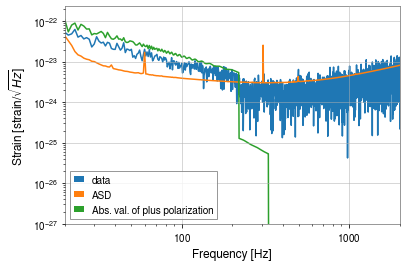

In [15]:
H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["plus"][idxs]),
          label="Abs. val. of plus polarization")

'''L1 = ifos[1]
L1_injection = injection[1]

ax.loglog(L1.frequency_array[idxs]+5,
          L1.amplitude_spectral_density_array[idxs],
          label="ASD")'''

ax.set_xlim(20,2000)
ax.set_ylim(1e-27,2.327737159425905e-22)


ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()